In [1]:
!pip install -q fastai2

In [2]:
!pip install -q iterative-stratification

In [3]:
from fastai2.vision.all import *
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [4]:
path = Path('../input/jovian-pytorch-z2g/Human protein atlas')

train_df = pd.read_csv(path/'train.csv')

train_df['Image'] = train_df['Image'].apply(str) + ".png"

train_df['Image'] = "../input/jovian-pytorch-z2g/Human protein atlas/train/" + train_df['Image']

train_df.head()

,Image,Label
0,../input/jovian-pytorch-z2g/Human protein atlas/train/19567.png,9
1,../input/jovian-pytorch-z2g/Human protein atlas/train/29993.png,6 4
2,../input/jovian-pytorch-z2g/Human protein atlas/train/17186.png,1 4
3,../input/jovian-pytorch-z2g/Human protein atlas/train/29600.png,6 2
4,../input/jovian-pytorch-z2g/Human protein atlas/train/701.png,3 4


In [5]:
strat_kfold = MultilabelStratifiedKFold(n_splits=3, random_state=42, shuffle=True)
train_df['fold'] = -1
for i, (_, test_index) in enumerate(strat_kfold.split(train_df.Image.values, train_df.iloc[:,1:].values)):
    train_df.iloc[test_index, -1] = i
train_df.head()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,Image,Label,fold
0,../input/jovian-pytorch-z2g/Human protein atlas/train/19567.png,9,1
1,../input/jovian-pytorch-z2g/Human protein atlas/train/29993.png,6 4,0
2,../input/jovian-pytorch-z2g/Human protein atlas/train/17186.png,1 4,0
3,../input/jovian-pytorch-z2g/Human protein atlas/train/29600.png,6 2,2
4,../input/jovian-pytorch-z2g/Human protein atlas/train/701.png,3 4,0


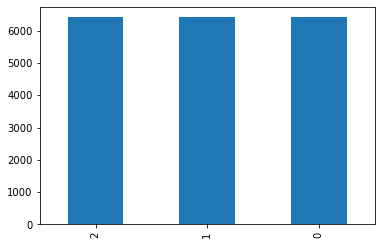

In [6]:
train_df.fold.value_counts().plot.bar();

In [7]:
def get_data(fold=0, size=224,bs=32):
    return DataBlock(blocks=(ImageBlock,MultiCategoryBlock),
                       get_x=ColReader(0),
                       get_y=ColReader(1, label_delim=' '),
                       splitter=IndexSplitter(train_df[train_df.fold == fold].index),
                       item_tfms=[FlipItem(p=0.5),Resize(512,method='pad')],
                   batch_tfms=[*aug_transforms(size=size,do_flip=True, flip_vert=True, max_rotate=180.0, max_lighting=0.6,max_warp=0.1, p_affine=0.75, p_lighting=0.75,xtra_tfms=[RandomErasing(p=0.5,sh=0.1, min_aspect=0.2,max_count=2)]),Normalize],
                      ).dataloaders(train_df, bs=bs)

In [8]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [9]:
def F_score(output, label, threshold=0.2, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [10]:
mixup = MixUp(0.3)

In [11]:
# def get_learner(fold, size=224):
#     dls = get_data(fold, size)
#     return cnn_learner(dls, resnet34, metrics=[partial(accuracy_multi, thresh=0.2),partial(F_score, threshold=0.2)],cbs=mixup).to_fp16()

In [12]:
test_df = pd.read_csv('../input/jovian-pytorch-z2g/submission.csv')
tstpng = test_df.copy()
tstpng['Image'] = tstpng['Image'].apply(str) + ".png"
tstpng['Image'] = "../input/jovian-pytorch-z2g/Human protein atlas/test/" + tstpng['Image']
tstpng.head()

,Image,Label
0,../input/jovian-pytorch-z2g/Human protein atlas/test/24117.png,0
1,../input/jovian-pytorch-z2g/Human protein atlas/test/15322.png,0
2,../input/jovian-pytorch-z2g/Human protein atlas/test/14546.png,0
3,../input/jovian-pytorch-z2g/Human protein atlas/test/8079.png,0
4,../input/jovian-pytorch-z2g/Human protein atlas/test/13192.png,0


In [13]:
import gc

In [14]:
all_preds = []

for i in range(3):
    dls = get_data(i,256,64)
    learn = cnn_learner(dls, resnet34, metrics=[partial(accuracy_multi, thresh=0.2),partial(F_score, threshold=0.2)],cbs=mixup).to_fp16()
    learn.fine_tune(10, cbs=EarlyStoppingCallback(monitor='valid_loss'))
    learn.dls = get_data(i,512,32)
    learn.fit_one_cycle(10,cbs=EarlyStoppingCallback(monitor='valid_loss'))
    tst_dl = learn.dls.test_dl(tstpng)
    preds, _ = learn.get_preds(dl=tst_dl)
    all_preds.append(preds)
    del learn
    torch.cuda.empty_cache()
    gc.collect()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.545962,0.344541,0.796662,0.325269,03:34


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.383005,0.320621,0.838335,0.343538,03:31
1,0.364457,0.307868,0.834389,0.395574,03:29
2,0.339153,0.288834,0.851154,0.424101,03:30
3,0.321231,0.276498,0.860605,0.500714,03:29
4,0.307015,0.262529,0.865237,0.526143,03:29
5,0.303211,0.252637,0.869339,0.542609,03:29
6,0.293627,0.246137,0.870898,0.557622,03:28
7,0.288911,0.240489,0.877324,0.567245,03:29
8,0.285248,0.237112,0.876575,0.589500,03:28
9,0.286031,0.236534,0.877339,0.590382,03:27


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.290949,0.315076,0.849766,0.462833,04:23
1,0.295474,0.320369,0.826154,0.472169,04:22


No improvement since epoch 0: early stopping


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.554367,0.340495,0.808827,0.318601,03:22


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.388593,0.319564,0.840362,0.331533,03:32
1,0.366437,0.307622,0.839379,0.363208,03:28
2,0.343576,0.290248,0.840876,0.402298,03:27
3,0.325350,0.281427,0.846164,0.467070,03:28
4,0.314482,0.266823,0.859451,0.469782,03:27
5,0.305747,0.257310,0.865830,0.517662,03:29
6,0.295284,0.248361,0.871881,0.546668,03:27
7,0.287226,0.242251,0.874298,0.563557,03:27
8,0.288487,0.239550,0.878041,0.570435,03:27
9,0.284914,0.238145,0.879196,0.570799,03:27


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.294379,0.344038,0.817124,0.550201,04:22
1,0.296755,0.330813,0.830053,0.424398,04:20
2,0.295352,0.260328,0.866110,0.477913,04:23
3,0.280896,0.259668,0.857954,0.598846,04:19
4,0.273494,0.218607,0.878868,0.645609,04:22
5,0.259204,0.200595,0.905396,0.653470,04:20
6,0.247184,0.209090,0.889878,0.687422,04:19


No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,accuracy_multi,F_score,time


In [15]:
subm = pd.read_csv("../input/jovian-pytorch-z2g/submission.csv")
preds = np.mean(np.stack(all_preds), axis=0)

In [16]:
learn.dls.vocab

NameError: name 'learn' is not defined

In [17]:
preds[0]

array([0.04565947, 0.08774102, 0.0536039 , 0.04304133, 0.9251135 ,
       0.01606368, 0.15841891, 0.02610746, 0.09389433, 0.06638951],
      dtype=float32)

In [18]:
thresh=0.2
labelled_preds = [' '.join([learn.dls.vocab[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

NameError: name 'learn' is not defined

In [19]:
test_df['Label']=labelled_preds

NameError: name 'labelled_preds' is not defined

In [20]:
test_df

,Image,Label
0,24117,0
1,15322,0
2,14546,0
3,8079,0
4,13192,0
...,...,...
8238,2982,0
8239,17414,0
8240,20223,0
8241,12031,0


In [21]:
test_df.to_csv('submission.csv',index=False)